### Importing all the relevant libraries and check the installed package versions

In [10]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pkg_resources
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sobol_seq
import time
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for rq in requirements:
    print("{}=={}".format(*rq))

seaborn==0.10.1
scipy==1.4.1
pandas==1.0.3
numpy==1.18.1
matplotlib==3.1.3


## Import the EC payments database

In [11]:
df = pd.read_excel('Database_Final_UPD_2020_corr.xlsx')

### Generate the series of quasi-random numbers for the analysis

In [12]:
quasiRandom_df = pd.DataFrame(sobol_seq.i4_sobol_generate(8,2**17))

DistributionFiMax = 0.8+quasiRandom_df[0]*0.2
DistributionFiMin = 0.2+quasiRandom_df[1]*0.2

Residue_selector = quasiRandom_df[2].round(0).astype(int)

DistributionFiMaxB = 0.8+quasiRandom_df[4]*0.2
DistributionFiMinB = 0.2+quasiRandom_df[5]*0.2

Residue_selectorB = quasiRandom_df[6].round(0).astype(int)

### Rearrange the dataframe for our convenience

In [13]:
dfb = df[['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year','CF_TOTAL','EAGGF','ERDF_TOTAL','ESF']].copy()
df2 = dfb.melt(id_vars=['ProgrammingPeriod','Country','NUTS1Code','NUTS2Code','Year'],var_name='FundingScheme')
df2b = df2[df2.Year<2018]
df3 = df2.pivot_table(index=['ProgrammingPeriod','FundingScheme','Country','NUTS1Code','NUTS2Code'],columns='Year', values='value')
df4 = df3.dropna(how='all').fillna(0)

### Get the slice corresponding to the set we'll be working on

In [ ]:
df4b = df4.loc[('2007-2013','ERDF_TOTAL')]

df4b.loc[pd.IndexSlice[:,:,'ITH1'],:]=df4b.loc[pd.IndexSlice[:,:,'ITH1'],:].values+\
df4b.loc[pd.IndexSlice[:,:,'ITH2'],:].values
df4b.loc[pd.IndexSlice[:,:,'ITH1'],:]
df4b=df4b.reset_index()
df4b.NUTS2Code[df4b.NUTS2Code=='ITH1']='ITH0'
df4b = df4b[df4b.NUTS2Code != 'ITH2']
df4b=df4b.set_index(['Country','NUTS1Code','NUTS2Code']).sort_index()

### Excluding years before the commencing of the programming periods

In [15]:
dummy = []

diff = int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][5:])+6-\
int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][:4])

d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in \
range(int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][:4]),
int(np.sort(np.array(list(set(df.ProgrammingPeriod))))[0][5:])+6)])

dummy.append(d_Var)

for pp in np.sort(np.array(list(set(df.ProgrammingPeriod))))[1:-1]:
    diff = int(pp[5:])+4-int(pp[:4])
    
    d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in range(int(pp[:4]),int(pp[5:])+4)])
    
    dummy.append(d_Var)
    
for pp in np.sort(np.array(list(set(df.ProgrammingPeriod))))[-1:]:
    diff = int(pp[5:])+5-int(pp[:4])
    
    d_Var = pd.Series([k/diff for k in range(1,diff+1)],[y for y in range(int(pp[:4]),int(pp[5:])+5)])
    
    dummy.append(d_Var)

### Normalise the cumulative figures

In [16]:
df5 = df4b.copy()

Norm_df6 = ((df5.cumsum(axis=1).T/df5.cumsum(axis=1).max(axis=1).values).T).dropna(how='all')

### Define the outcome variables

In [17]:
Norm_df6['$\phi$']=(Norm_df6.loc[:,[y for y in range(2007,2018)]]-dummy[-1]).cumsum(axis=1).iloc[:,-1]

Norm_df6['$\mu$']=(Norm_df6['$\phi$'].max()-Norm_df6['$\phi$'])/(Norm_df6['$\phi$'].max()-Norm_df6['$\phi$'].min())

### Set the trigger for the number of years the residual expenditure gets spread onto on the last eligible year of the programming period

In [18]:
ld1 = []
ld1b = []
for iq,qr in enumerate(quasiRandom_df[3]):
    df8b = Norm_df6.copy()
    df8c = Norm_df6.copy()
    df8b[0]=(qr*(Norm_df6['$\mu$']*(len(dummy[-1])-1)).astype(int)).astype(int)+1
    df8c[0]=(quasiRandom_df[7][iq]*(Norm_df6['$\mu$']*(len(dummy[-1])-1)).astype(int)).astype(int)+1
    for il in range(1,len(dummy[-1])):
        df8b[il]=df8b[0]-il
        df8c[il]=df8c[0]-il
    df8b[df8b<1]=1
    df8c[df8c<1]=1
    cd = [il0 for il0 in range(len(dummy[-1]))]
    df8b['value']=iq
    df8c['value']=iq
    cd.append('value')
    df8b = df8b[cd]
    df8c = df8c[cd]
    ld1.append(df8b)
    ld1b.append(df8c)
years = pd.concat(ld1)
yearsB = pd.concat(ld1b)
years.set_index('value', append=True, inplace=True)
yearsB.index = years.index

### Define the yearly residues

In [19]:
def A(n):
    return [2**j/(2**n-1) for j in reversed(range(n))]

B9 = []
for k in reversed(range(2,12)):
    B9.append(pd.DataFrame([A(y) for y in range(1,k)],index=[y for y in range(1,k)],
                           columns=[y for y in range(1,k)]).fillna(0).sort_values(by=1,ascending=False))

### And the number of years from which the Excess get taken out

In [20]:
def C(n):
    return [1/n for j in reversed(range(n))]

C9 = pd.DataFrame([C(y) for y in range(1,11)],index=[y for y in range(1,11)],
                           columns=[y for y in range(1,11)]).fillna(0).sort_values(by=1,ascending=False)

D = [C9,pd.DataFrame([A(y) for y in range(1,11)],index=[y for y in range(1,11)],
                           columns=[y for y in range(1,11)]).fillna(0).sort_values(by=1,ascending=False)]

## Get the EC payment slice for Italy

In [21]:
Payments = df4b.loc['IT'].iloc[:,-12:].copy()
Payments.index=Payments.index.droplevel(0)

### Get the member-state figure our data will be compared against

In [ ]:
df1 = pd.read_excel('20181231 Pagamenti ammessi PO 2007-2013.xls',usecols=[0,1,2,3,4,5,7])
df_REGIO_capped = df1[(df1['CCI'].str.contains("161"))|df1['CCI'].str.contains("162")]
NUTS2_dic = {'ABRUZZO':'ITF1','BASILICATA':'ITF5','CALABRIA':'ITF6','CAMPANIA':'ITF3','EMILIA':'ITH5','FRIULI':'ITH4','LAZIO':'ITI4',
'LIGURIA':'ITC3','LOMBARDIA':'ITC4','MARCHE':'ITI3','MOLISE':'ITF2','PIEMONTE':'ITC1','PUGLIA':'ITF4','SARDEGNA':'ITG2','SICILIA':'ITG1',
'TOSCANA':'ITI1','TRENTINO':'ITH0','UMBRIA':'ITI2',"VALLE D'AOSTA":'ITC2','VENETO':'ITH3'}

df_REGIO_capped['NUTS2'] = df_REGIO_capped.REGIONE.map(NUTS2_dic)

df_REGIO_capped.DESCRIZIONE_PROGRAMMA = df_REGIO_capped.DESCRIZIONE_PROGRAMMA.str.replace(' Romagna', '')

### Attribute the orphan payments

In [ ]:
df_REGIO_capped.loc[df_REGIO_capped['NUTS2'].isnull(),'NUTS2'] = \
df_REGIO_capped['DESCRIZIONE_PROGRAMMA'].str.split(expand=True)[3].map(NUTS2_dic)

df_REGIO_nonAttributed = df_REGIO_capped[df_REGIO_capped.NUTS2.isna()]
df_REGIO_REGIO = df_REGIO_capped.dropna()

df_REGIO_REGIO=df_REGIO_REGIO.rename(columns={'ANNO':'Year'})

df_REGIO_REGIO_yearly=df_REGIO_REGIO.groupby(['Year','NUTS2']).sum()
df_REGIO_REGIO_yearly['Year']=df_REGIO_REGIO_yearly.index.get_level_values(0)
df_REGIO_REGIO_yearly=df_REGIO_REGIO_yearly
df_REGIO_REGIO_yearly.index= df_REGIO_REGIO_yearly.index.droplevel(0)

df_REGIO_pv = df_REGIO_REGIO_yearly.pivot_table(index='Year', columns='NUTS2', values='PAGAMENTO_AMMESSO_UE').fillna(0).T

### Re-distribute the residues as per the NUTS2 expenditures

In [24]:
df_REGIO_multiplier_year=df_REGIO_nonAttributed.groupby('ANNO').sum().T.values*df_REGIO_pv/df_REGIO_pv.sum()

df_REGIO_multiplier_year['r']=1

df_REGIO_multiplier = df_REGIO_nonAttributed.groupby('ANNO').sum().T.values*\
pd.concat([df_REGIO_pv.sum(axis=1)/df_REGIO_pv.sum(axis=1).sum() for re in range(12)],axis=1)
df_REGIO_multiplier['r']=0
df_REGIO_multiplier.columns = df_REGIO_multiplier_year.columns

df_REGIO_residual = pd.concat([df_REGIO_multiplier,df_REGIO_multiplier_year])

### Evaluate the distance between the modelled expenditure and the MS incurred

In [25]:
Expe = pd.concat([Payments.copy() for r in range(len(quasiRandom_df))])

Est_expenditure = pd.concat([df_REGIO_pv.copy() for r in range(len(quasiRandom_df))])

sampler = [DistributionFiMax,DistributionFiMin,Residue_selector,years,
           DistributionFiMaxB,DistributionFiMinB,Residue_selectorB,yearsB]

Distance_l = []
for ix in range(6):
    sampler_scrambled = sampler.copy()
    if  1<=ix<=4:
        sampler_scrambled[ix-1] = sampler[ix+3]
    elif ix == 5:
        sampler_scrambled = sampler_scrambled[int(len(sampler_scrambled)/2):] 
    Exp = Expe.copy()

    Exp['r']=np.array([r for r in range(len(quasiRandom_df)) for er in range(len(Payments))])
    N_df = pd.concat([Norm_df6.loc['IT','$\mu$'] for r in range(len(quasiRandom_df))])
    N_df.index = N_df.index.droplevel(0) 

    y_slice = sampler_scrambled[3].loc[pd.IndexSlice['IT',:,:]]
    y_slice.index = y_slice.index.droplevel(0)

    Exp.loc[:,2017]=Expe.loc[:,[y for y in range(2017,2019)]].sum(axis=1)
    Exp.loc[:,[y for y in range(2018,2019)]]=0

    Aggregate = Exp.loc[:,2017]*(1-(sampler_scrambled[0][Exp.r].values-N_df*
                                (sampler_scrambled[0][Exp.r]-sampler_scrambled[1][Exp.r]).values))
    
    Exp.loc[:,2017] = Exp.loc[:,2017]*(sampler_scrambled[0][Exp.r].values-N_df*
                                (sampler_scrambled[0][Exp.r]-sampler_scrambled[1][Exp.r]).values)

    residual = pd.concat(df_REGIO_residual[df_REGIO_residual.r==rs] for rs in sampler_scrambled[2])

    for iy2,y2 in enumerate(reversed(range(2007,2017))):
        Exp[y2] = Expe[y2]*(sampler_scrambled[0][Exp.r].values-N_df*(sampler_scrambled[0][Exp.r]-sampler_scrambled[1][Exp.r]).values)

        for iy3,y3 in enumerate(reversed(range(y2,2016))):
            Exp[y2]+=Expe[y3+1]*(1-sampler_scrambled[0][Exp.r].values+N_df*(sampler_scrambled[0][Exp.r]-\
                    sampler_scrambled[1][Exp.r]).values)*B9[iy3].loc[y_slice.iloc[:,iy3].values,(y3+1-y2)].values

        Exp[y2] += Aggregate*B9[0].loc[y_slice.iloc[:,0],iy2+1].values

    Exp[2007] += Expe[2007]*(1-sampler_scrambled[0][Exp.r].values+N_df*(sampler_scrambled[0][Exp.r]-sampler_scrambled[1][Exp.r]).values)
    Exp = Exp.drop('r',axis=1)

    MS_Expenditure = (Est_expenditure+residual).drop('r',axis=1)

    Distance = pd.DataFrame((np.abs(MS_Expenditure.cumsum(axis=1)-Exp.cumsum(axis=1)).sum(axis=1)/\
                             Expe.cumsum(axis=1).iloc[:,-1])).rename(columns={2016:'Distance'})

    Distance['r']=np.array([r for r in range(len(quasiRandom_df)) for er in range(len(Payments))])

    Distance_df = Distance.pivot_table(values=0,index='r',columns='NUTS2')

    Distance_payments = pd.DataFrame((np.abs(MS_Expenditure.cumsum(axis=1)-Expe.cumsum(axis=1)).sum(axis=1)/\
                             Expe.cumsum(axis=1).iloc[:,-1])).rename(columns={2016:'Distance'})

    Distance_payments['r']=Distance['r']

    Distance_payments_df = Distance_payments.pivot_table(values=0,index='r',columns='NUTS2')
    Distance_l.append(Distance_df)

### Sensitivity analysis

In [29]:
Sa_G = []
T_G = []
for imb,mb in enumerate(Distance_l[1:-1]):
    Var = pd.concat([Distance_l[0],Distance_l[-1]]).var(ddof=0)
    Sa_G.append(((mb-Distance_l[0])*Distance_l[-1]).mean()/Var)
    T_G.append((0.5*(mb-Distance_l[0])**2).mean()/Var)

In [30]:
pd.concat(T_G,axis=1).to_csv('T.csv')
pd.concat(Sa_G,axis=1).to_csv('Sa.csv')

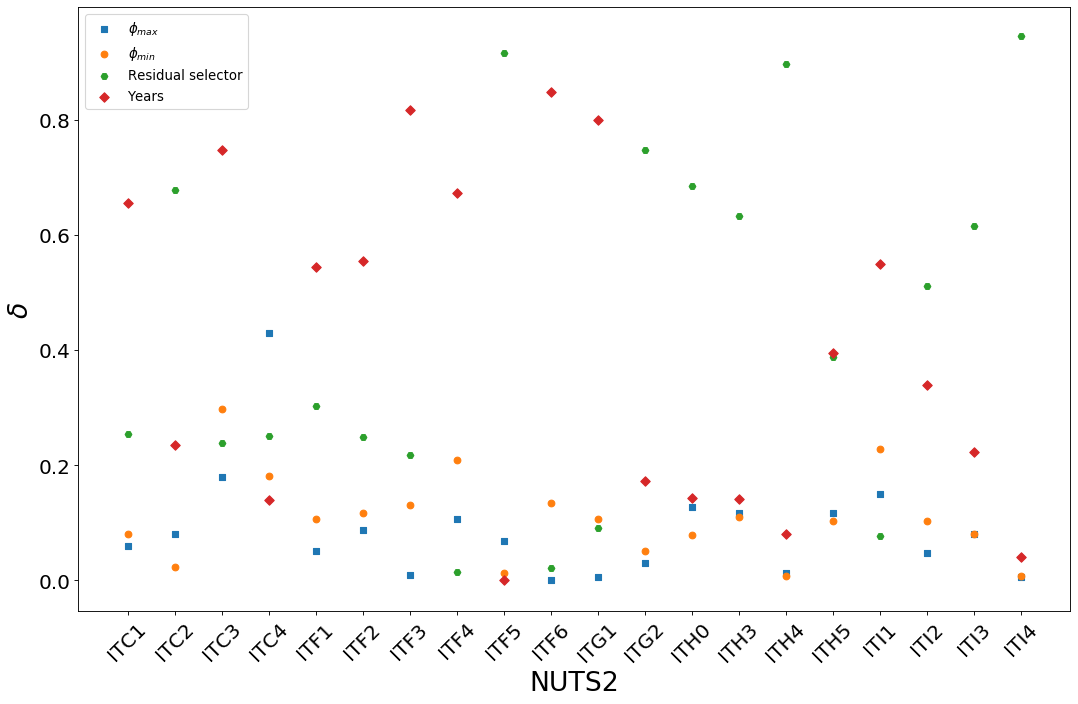

In [65]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.tight_layout()
labels = ['$\phi_{max}$','$\phi_{min}$','Residual selector','Years']
shapes = ['s','o','H','D']
T_df = pd.concat(T_G,axis=1)
for ic,c in enumerate(T_df):
    plt.scatter([r for r in range(len(T_df))],T_df[c],marker=shapes[ic],label = labels[ic])
plt.ylabel('$\delta$',fontsize = 24)
plt.xlabel('NUTS2',fontsize = 24)
plt.xticks(ticks= [r for r in range(len(T_df))],labels=T_df.index,fontsize = 18)
plt.xticks(rotation=45); plt.yticks(fontsize=18)
plt.legend(prop={'size': 12})
plt.show()